In [1]:
import os, glob, sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
%matplotlib inline
import skimage
from skimage.io import imread, imshow, imsave
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import time
import functools
from eval import *
from ShowColors import *
from ImportUtil import *
import random
%env CITYSCAPES_DATASET = /home/rvygon/data/
from tensorflow.metrics import *
%load_ext autoreload
%autoreload 2


env: CITYSCAPES_DATASET=/home/rvygon/data/


In [2]:
IMG_SHAPE = (1024, 2048, 3)
EPOCHS = 300
BATCH_SIZE = 1
TOTAL_SIZE = 500
EPOCH_SIZE = TOTAL_SIZE
VAL_SIZE = 25
SCALE_RATE = 1
VERBOSE = 1
START_INDEX = 0

In [3]:
### AUGMENTATION BLOCK

def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label            

def crop_img(crop_rate, image, label):
    if crop_rate is not None:
        image = tf.image.resize_images(tf.image.central_crop(image, crop_rate), (IMG_SHAPE[0], IMG_SHAPE[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.image.resize_images(tf.image.central_crop(label, crop_rate), (IMG_SHAPE[0], IMG_SHAPE[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

def _augment(image,
             label,
             hue_delta=0,
             horisontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_rate=None):
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    image, label = crop_img(crop_rate, image, label)
    return image, label
def to_tensor(image, label):
    return image, label

tr_cfg = {
    'hue_delta': 0.2,
    'horisontal_flip': True,
    'crop_rate' : 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)



In [4]:
from tensorflow.python.keras.utils import to_categorical

x_train_data, y_train_data = importBatch(TOTAL_SIZE,
                                         START_INDEX,
                                         verbose=VERBOSE,
                                         type='train',
                                         scale=SCALE_RATE)
y_train_data = to_categorical(y_train_data)
x_train_data = x_train_data.astype('uint8')
y_train_data = y_train_data.astype('uint8')

x_val_data, y_val_data, files = importBatch(VAL_SIZE,
                                            START_INDEX,
                                            verbose=VERBOSE,
                                            type='val',
                                            scale=SCALE_RATE)
y_val_data = to_categorical(y_val_data)
x_val_data = x_val_data.astype('uint8')
y_val_data = y_val_data.astype('uint8')


loaded files input -  100
loaded files output -  100


In [5]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdLabelImgs
def upd_print(str):
    sys.stdout.write('\r')       
    sys.stdout.write(str)
    sys.stdout.flush()

def _tversky_loss(alpha=0.5, beta=0.5):
    def tversky_loss(y_true, y_pred):    
        ones = K.ones(K.shape(y_true))
        p0 = y_pred      # proba that pixels are class i
        p1 = ones - y_pred # proba that pixels are not class i
        g0 = y_true
        g1 = ones - y_true

        num = K.sum(p0 * g0, (0, 1, 2))
        den = num + alpha * K.sum(p0 * g1, (0, 1, 2)) + beta * K.sum(p1 * g0, (0, 1, 2)) + 1e-8

        T = K.sum(num / den) # when summing over classes, T has dynamic range [0 Ncl]

        classNumber = K.cast(K.shape(y_true)[-1], 'float32') ### equal classNumber = 20.0
        return classNumber - T
    return tversky_loss

In [6]:
def unet(pretrained_weights=None, input_size=IMG_SHAPE):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'softmax')(conv9)

    model = Model([inputs], [conv10])

    model.compile(optimizer=Adam(lr=5e-4),
                  loss=tversky_loss,
                  metrics=['accuracy'])

    if pretrained_weights != None:
        model.load_weights(pretrained_weights)

    return model

In [7]:
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image



In [8]:
def vgg_unet(lr=1e-4, alpha=0.5, beta=0.5, input_size=IMG_SHAPE):
    vgg_model = VGG19(input_shape=IMG_SHAPE, include_top=False)

    conv1 = vgg_model.get_layer('block2_conv1').output #shape 128 256 64
    conv2 = vgg_model.get_layer('block2_pool').output #shape 64 128 64
    conv3 = vgg_model.get_layer('block4_conv4').output #shape 32 64 128
    conv4 = vgg_model.get_layer('block5_conv4').output #shape 16 32 256
    conv5 = vgg_model.get_layer('block5_pool').output #shape 8 16 512
    
    conc_1 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    
    conc_2 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    
    conc_3 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv3), conv2])
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    
    conc_4 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv2), conv1])
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    
    conc_5 = UpSampling2D(size=(2, 2))(conv_conc_4)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    
    last = Conv2D(20, 1, activation = 'softmax')(conv_conc_5)
    
    model = Model(vgg_model.input, last)
    
    model.compile(optimizer = Adam(lr = lr), loss = _tversky_loss(alpha, beta), metrics = ['accuracy'])
    return model

In [9]:
#without new
from tensorflow.keras.callbacks import CSVLogger
# TODO SPECIFY ALPHA BETA IN TVERSKY LOSS
def run(params):
    LR, ALPHA = params
    BETA = 1 - ALPHA
    print('Starting training...')

    csv_logger = CSVLogger('bayesian_logs/logs_kimtensor_300.csv', append=True, separator=';')

    tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, 
          write_graph=True, write_images=True)

    class FeedBatch(tf.keras.callbacks.Callback):
        def on_epoch_end(self, logs={}, idk=0):
            x_train_data, y_train_data = importRandomBatch(EPOCH_SIZE, 'train', SCALE_RATE)
            y_train_data = to_categorical(y_train_data)
            x_train_data = x_train_data.astype('uint8')
            y_train_data = y_train_data.astype('uint8')
            with tf.Session() as sess:
                sess.run(iteratorTrain.initializer, feed_dict={features_placeholder: x_train_data,
                                                         labels_placeholder: y_train_data})

    feed_batch = FeedBatch()
    history = None
    with tf.Session() as sess:
        features_placeholder = tf.placeholder(x_train_data.dtype, x_train_data.shape)
        labels_placeholder = tf.placeholder(y_train_data.dtype, y_train_data.shape)

        dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
        dataset = dataset.repeat().batch(BATCH_SIZE)

        iteratorTrain = dataset.make_initializable_iterator()
        sess.run(iteratorTrain.initializer, feed_dict={features_placeholder: x_train_data,
                                              labels_placeholder: y_train_data})

        features_val_placeholder = tf.placeholder(x_val_data.dtype, x_val_data.shape)
        labels_val_placeholder = tf.placeholder(y_val_data.dtype, y_val_data.shape)

        dataset_val = tf.data.Dataset.from_tensor_slices((features_val_placeholder, labels_val_placeholder))
        dataset_val = dataset_val.repeat().batch(BATCH_SIZE)

        iteratorVal = dataset_val.make_initializable_iterator()
        sess.run(iteratorVal.initializer, feed_dict={features_val_placeholder: x_val_data,
                                                     labels_val_placeholder: y_val_data})
        vgg_model = vgg_unet(LR, ALPHA, BETA)

    #     vgg_model = load_model('vgg_unet_tensorflow_new2.hdf52', custom_objects={'tversky_loss': tversky_loss})

        model_checkpoint = ModelCheckpoint('vgg_unet_tensorflow_300.hdf5',
                                           monitor='loss',
                                           verbose=VERBOSE,
                                           save_best_only=True)
        print('Started fitting...')
        sess.run(tf.global_variables_initializer())
        history = vgg_model.fit(iteratorTrain,
                            steps_per_epoch=int(TOTAL_SIZE / BATCH_SIZE),
                            epochs=EPOCHS,
                            callbacks=[feed_batch, model_checkpoint, csv_logger, tbCallBack],
                            validation_data=iteratorVal,
                            validation_steps=VAL_SIZE)
        print('Fitting successfuly completed, returning history...')
        sess.close()
    return history

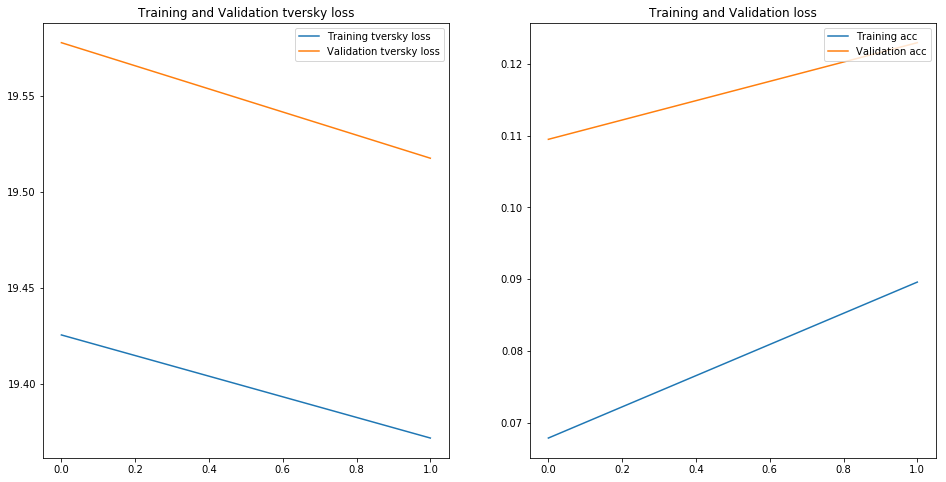

In [66]:
#tversky_loss_hist = history.history['loss']
#val_tversky_loss_hist = history.history['val_loss']
#
#acc = history.history['acc']
#val_acc = history.history['val_acc']
#
#epochs_range = range(2)
#
#plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, tversky_loss_hist, label='Training tversky loss')
#plt.plot(epochs_range, val_tversky_loss_hist, label='Validation tversky loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation tversky loss')
#
#plt.subplot(1, 2, 2)
#plt.plot(epochs_range, acc, label='Training acc')
#plt.plot(epochs_range, val_acc, label='Validation acc')
#plt.legend(loc='upper right')
#plt.title('Training and Validation loss')
#
#plt.show()

In [10]:
"""sampling loss with a batch of parameters"""
""" params : lr, alpha, beta"""
PARAMS_SHAPE = (2)
def sample_loss(params):
    hist = run(params)
    val_tversky_losses = hist.history['loss']
    print('HISTORY OF LOSS: ', val_tversky_losses)
    average_loss = np.mean(val_tversky_losses)
    print('Average loss: ', average_loss)
    return average_loss

In [ ]:
run([4.53970551e-04, 5.43964131e-01])

In [11]:
from bayes.bayesian import expected_improvement, sample_next_hyperparameter, bayesian_optimization
bounds = [[1e-4, 1e-3], [0.3, 0.7]]
bounds = np.array(bounds)
xp, yp = bayesian_optimization(n_iters=10, 
                               sample_loss=sample_loss, 
                               bounds=bounds, n_initial=2)

[1.50683296e-04 5.89753850e-01]
Starting training...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Started fitting...
Epoch 1/1
100/100 [==============================] - 172s 2s/step - loss: 18.9543 - acc: 0.3585 - val_loss: 18.9532 - val_acc: 0.2042

Epoch 00001: loss improved from inf to 18.95427, saving model to vgg_unet_tensorflow_new2.hdf5
Fitting successfuly completed, returning history...
HISTORY OF LOSS:  [18.95426504135132]
Average loss:  18.95426504135132
[3.00381845e-04 3.86106495e-01]
Starting training...
Started fitting...
Epoch 1/1
100/100 [==============================] - 160s 2s/step - loss: 18.9946 - acc: 0.3633 - val_loss: 19.2357 - val_acc: 0.1557

Epoch 00001: loss improved from inf to 18.99465, saving model to vgg_unet_tensorflow_new2.hdf5
Fitting successfuly completed, returning history...
HISTORY OF LOSS:  [18.994648818969726]
Average loss:  18.994648818969726
Started iterations of bayesian model...
Starting training...
Starte

In [12]:
print(xp)
print(yp)
# with open('xp_yp.txt', 'a') as f:
#     for x, y in zip(xp, yp):
#         f.write('x : ')
#         for i in x:
#             f.write('%s ' % str(i))
#         f.write('y : %s\n' % str(y))

[[1.50683296e-04 5.89753850e-01]
 [3.00381845e-04 3.86106495e-01]
 [1.00000000e-04 7.00000000e-01]
 [7.61257245e-04 5.60624501e-01]
 [1.00000000e-03 5.01995979e-01]
 [8.57440196e-04 5.45002526e-01]
 [7.57840784e-04 6.54044518e-01]
 [5.85067316e-04 5.86348765e-01]
 [5.07955380e-04 5.40636488e-01]
 [4.23332254e-04 4.50040035e-01]
 [4.94848816e-04 5.83264704e-01]
 [7.12892304e-04 4.36918793e-01]]
[18.95426504 18.99464882 18.80415478 18.58421516 18.55448795 18.65550074
 18.45278326 18.80288147 18.62614994 18.86811489 18.71223358 18.70809067]


In [74]:
model = load_model('vgg_unet_tensorflow_new2.hdf52', custom_objects={'tversky_loss': tversky_loss})

OSError: Unable to open file (unable to open file: name = 'vgg_unet_tensorflow_new2.hdf52', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

1/1 [==============================] - 3s 3s/step


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


200/200 [==============================] - 136s 681ms/step
processed 199 images
road : 0.446792231170184
sidewalk : 0.02983160742666017
building : 0.2973786972675595
wall : 0.000130976315465071
fence : 4.998846253548767e-07
pole : 0.1331985995524162
traffic light : 2.3905143027929035e-05
traffic sign : 0.14356539376582567
vegetation : 0.5815218577096317
terrain : 0.01641252342750924
sky : 0.462183703985105
person : 0.10676776290653729
rider : 7.249003262051468e-07
car : 0.1361046456272593
truck : 0.0
bus : 0.0
train : 0.0
motorcycle : 0.0
bicycle : 0.02135575747146618
0.12944399654332692


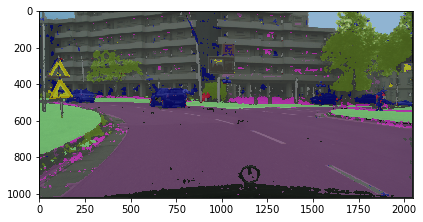

In [49]:
def showRandomImage():
    randomImageId = random.randint(0, EPOCH_SIZE)
    x_pred = model.predict(x_train_data[randomImageId:randomImageId + 1],
                           verbose=1)
    pred_image = np.argmax(x_pred[0], axis=2).astype(int)
    colorImage(x_train_data[randomImageId],
               pred_image,
               'classes.txt',
               'colors.txt')

    return 0

def eval_model(model):
        x_pred = model.predict(x_val_data, verbose=1, batch_size=1)        
        new_x = np.argmax(x_pred, axis=3)
        new_x = new_x.astype(int)
        y_val = np.argmax(y_val_data, axis=3)
        score = eval_preds(new_x, y_val)        
        return score
#x_pred = model.predict(x_val_data[0:4],
#                       verbose=1)
#pred_image = np.argmax(x_pred[2], axis=2).astype(int)
#pred_image.shape
#y_img = np.argmax(y_val_data[2], axis=2).astype(int)
#y_img.shape
#colorImage(x_val_data[2], pred_image, 'classes.txt', 'colors.txt')
showRandomImage()

print(eval_model(model))